In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import os
import glob
import random

import config
import utils


In [2]:
from keras.models import Model
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D, Input, concatenate, Activation,LeakyReLU
from keras import backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD


Using TensorFlow backend.


In [8]:
# Set model_filename to either name of a file to which a new trained model has to be saved or to a name of a file from which
# trained model weights have to be loaded

model_filename = 'regresja1.h5'


In [4]:
# Read all simulated profiles for a regular grid of primary beam parameters, for fields 3x3, 10x10, and 30x30

dataPoints = [(str(e),str(se),str(s),str(an)) for e in config.simulatedEnergies for se in config.simulatedEnergyDispersions for s in config.simulatedSourceSizes 
              for an in config.simulatedAngularDivergences]

random.seed(config.SEED)
random.shuffle(dataPoints)

profiles = utils.readProfiles(config.profileDIR,dataPoints)

profiles = np.asarray(profiles)
y_train = np.asarray(dataPoints,dtype=np.float)

print(profiles.shape,y_train.shape)

(3, 300, 6, 495) (300, 4)


In [5]:

X_train = []

for nfield,(field,Ranges) in enumerate(zip(config.analyzedProfiles,config.analyzedRanges)):
    if field != None:
        for profile,Range in zip(field,Ranges):
            inp = profiles[nfield,:,profile,Range[0]:Range[1]]
            inp = np.reshape(inp,inp.shape + (1,))
            print(inp.shape)
            X_train.append(inp)
            

(300, 348, 1)
(300, 141, 1)
(300, 348, 1)
(300, 231, 1)
(300, 491, 1)


In [6]:
from keras.layers import Conv1D,MaxPooling1D,Concatenate,Flatten,Dense

def conv_block(inp,filters=16,kernel_size=3,strides = 1,kernel_initializer= 'glorot_uniform',padding='same',activation='relu'):
    c = Conv1D(filters,kernel_size,kernel_initializer=kernel_initializer,padding=padding,activation=activation,strides = strides)(inp)
    c = Conv1D(filters,kernel_size,kernel_initializer=kernel_initializer,padding=padding,activation=activation,strides = strides)(c)
    c = MaxPooling1D(2)(c)
    return c

inputs = []
outputs = []
for nmod in range(len(config.allRanges)):
    shape = (config.allRanges[nmod][1]-config.allRanges[nmod][0],1)
    print(shape)
    W = int(np.log(shape[0]/3)/np.log(2))
    inp = Input(shape)
    F = 16
    x = inp
    for w in range(W):
        x = conv_block(x,filters = F)
        F *= 2
    out = Conv1D(1,1) (x)
    inputs.append(inp)
    outputs.append(out)

c = Concatenate(axis=1)(outputs)
c = Flatten()(c)
c = Dense(100,activation='relu')(c)
c = Dense(100,activation='relu')(c)
out = Dense(4,activation=None)(c)

model = Model(inputs = inputs,outputs=[out])
#model.summary()

(348, 1)
(141, 1)
(348, 1)
(231, 1)
(491, 1)


In [7]:

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True
)

model.compile(
    optimizer=Adam(lr=0.0001), 
    loss = 'mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [ ]:
# Run only if the trained model does not yet exist exists

history = model.fit(
    X_train,y_train,
    steps_per_epoch=100,
    epochs=300,
    validation_split=0.2,
    validation_steps = 10,
    callbacks=[callback_checkpoint]
)


In [9]:
# Run if the trained model already exists

model.load_weights(model_filename)

In [10]:
groundTruthFilename = config.testProfilesDIR + config.groundTruthFileName

testGoals = open(groundTruthFilename)
lines = testGoals.readlines()
y_test = [l[:-1].split()[1:5] for l in lines[:-1]]
fileNames = [l[:-1].split()[0] for l in lines[:-1]]
testGoals.close()

fields = ['fields','fields10','fields30']
testProfiles3 = []
testProfiles10 = []
testProfiles30 = []

for fileName in fileNames:
    name = config.testProfilesDIR + fileName + '_' + fields[0] + '.npz'
    file = np.load(name)
    testProfiles3.append(file[file.files[1]])

    name = config.testProfilesDIR + fileName + '_' + fields[1] + '.npz'
    file = np.load(name)
    testProfiles10.append(file[file.files[1]])

    name = config.testProfilesDIR + fileName + '_' + fields[2] + '.npz'
    file = np.load(name)
    testProfiles30.append(file[file.files[1]])
        

testProfiles = []
testProfiles.append(testProfiles3)
testProfiles.append(testProfiles10)
testProfiles.append(testProfiles30)

testProfiles = np.asarray(testProfiles,dtype=np.float)
y_test = np.asarray(y_test,dtype=np.float)

print(testProfiles.shape,y_test.shape)

(3, 25, 6, 495) (25, 4)


In [11]:

X_test = []

for nfield,(field,Ranges) in enumerate(zip(config.analyzedProfiles,config.analyzedRanges)):
    if field != None:
        for profile,Range in zip(field,Ranges):
            inp = testProfiles[nfield,:,profile,Range[0]:Range[1]]
            inp = np.reshape(inp,inp.shape + (1,))
            print(inp.shape)
            X_test.append(inp)


(25, 348, 1)
(25, 141, 1)
(25, 348, 1)
(25, 231, 1)
(25, 491, 1)


In [12]:
y_predicted = model.predict(X_test)
print(y_predicted.shape)

(25, 4)


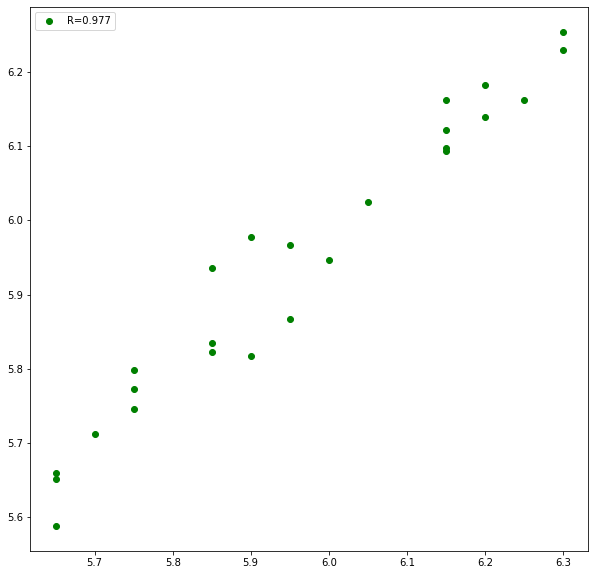

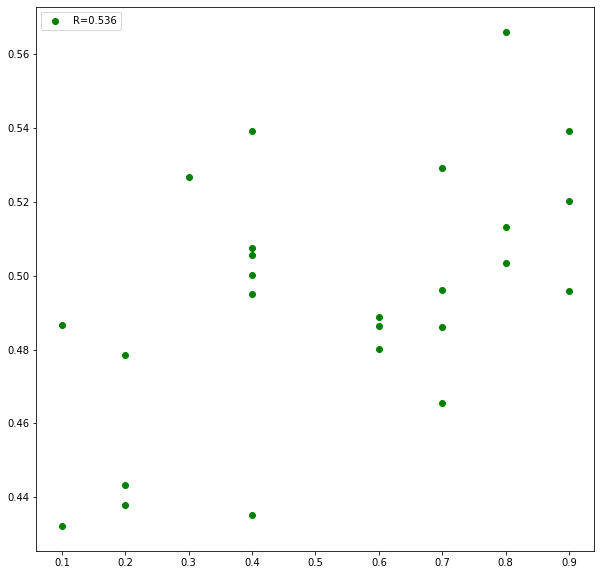

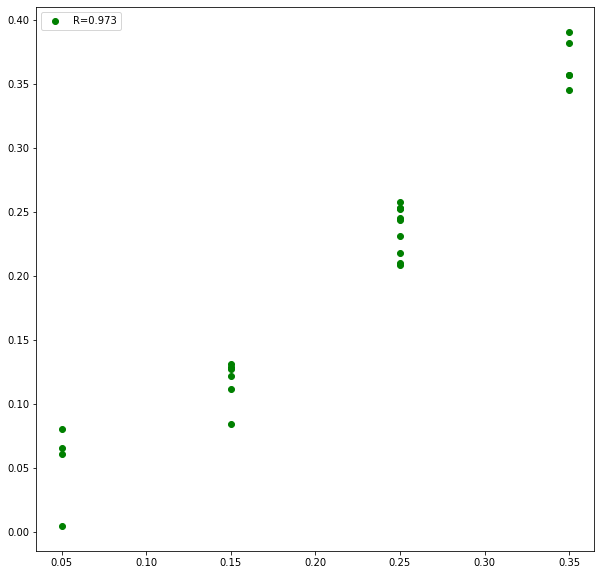

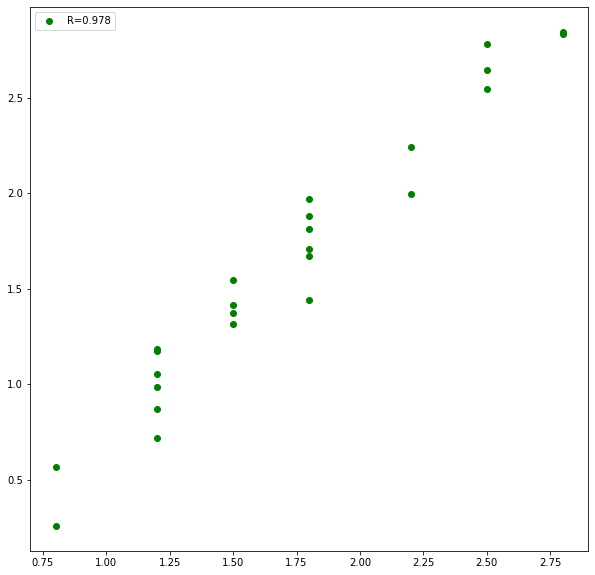

In [13]:
from scipy.stats import pearsonr

for par in range(4):
    plt.figure(figsize=(10,10))
    corr, _ = pearsonr(y_test[:,par], y_predicted[:,par])
    plt.plot(y_test[:,par],y_predicted[:,par],'og',label='R='+str(np.round(corr,3)))
    plt.legend(loc='upper left')
    plt.show()